## MATH 440 Optimal Stopping Problems in Discrete Time(Binomial Trees & LSM)  
### Mar 10, 2025

**Instruction:** This is a comparison between the two models that we've implemented separately. We set the parameters the same/of similar values, and compares the option value in different perspectives. Moreover, we can try different degrees for the Regression Fit of LSM.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
from time import time

### Parameters Settings

In [4]:
S0=100 #Initial Stock Price
K=100 #Strike Price
r=0.05 #Risk-free Interest Rate/Discount Rate
sigma=0.2 #Volatility
T=1 #Final Time
N_tree=1000 #Number of Time Steps
N_lsm=50 #Time Steps for LSM
M=100000 #n of paths for LSM

### Binomial Trees

Since the original binomial trees model and the LSM models are not directly matched, here we do the **Binomial Tree Parameter Calibration**  
Corrected CRR Formulas:
\begin{align*}
\Delta t &= \frac{T}{N} \\
u &= e^{\sigma \sqrt{\Delta t}} \quad &\text{(Up factor)} \\
d &= e^{-\sigma \sqrt{\Delta t}} = \frac{1}{u} \quad &\text{(Down factor)} \\
p &= \frac{e^{r \Delta t} - d}{u - d} \quad &\text{(Risk-neutral probability)}
\end{align*}
Speicifically, we require the following criterion to be met:
1. Volatility Matching: $\frac{\ln u - \ln d}{2\sqrt{\Delta t}} \equiv \sigma$
2. No-Arbitrage Guarantee: $d < e^{r\Delta t} < u \quad \text{always holds}$
3. Black-Scholes Consistency: $\lim_{N\to\infty} \text{Binomial Price} = \text{Black-Scholes Price}$

In [6]:
def Binomial(S0,K,r,sigma,T,N):
    dt=T/N
    u=np.exp(sigma*np.sqrt(dt))
    d=1/u
    p=(np.exp(r*dt)-d)/(u-d)

    S_tree=np.zeros((N+1, N+1))
    S_tree[0,0]=S0
    for t in range(1, N+1):
        S_tree[:t, t]=S_tree[:t,t-1]*u
        S_tree[t, t]=S_tree[t-1,t-1]*d
    V_tree=np.zeros_like(S_tree)
    V_tree[:,N]=np.maximum(K-S_tree[:,N],0)    
    for t in range(N-1,-1,-1):
        hold=np.exp(-r*dt)*(p*V_tree[:t+1,t+1]+(1-p)*V_tree[1:t+2, t+1])
        exercise=np.maximum(K-S_tree[:t+1,t],0)
        V_tree[:t+1,t]=np.maximum(hold,exercise)   
    return V_tree[0, 0]

### LSM

In [7]:
def paths_mc_gbm(S_0,r,sigma,T,N,M):
    dt=T/N
    paths=np.zeros((M,N+1))#with each row denotes different paths and cols denote time series
    paths[:,0]=S_0
    for t in range(1,N+1):
        Z=np.random.normal(0, 1, M)
        paths[:,t]=paths[:,t-1]*np.exp((r-0.5*sigma**2)*dt+sigma*np.sqrt(dt)*Z)
    return paths

def lsm_fit_model(S_0,K,r,sigma,T,N,M,degree):
    dt=T/N
    paths=paths_mc_gbm(S_0,r,sigma,T,N,M)
    V=np.zeros_like(paths)
    V[:,-1]=np.maximum(K-paths[:,-1],0)
    exercise=np.zeros_like(paths, dtype=bool)
    exercise[:,-1]=V[:,-1]>0
    
    for t in range(N-1,0,-1):
        in_the_money=paths[:,t]<K #in-money filter
        X=paths[in_the_money,t].reshape(-1,1)
        
        poly=PolynomialFeatures(degree)
        X_poly=poly.fit_transform(X)
        Y=V[in_the_money,t+1]*np.exp(-r*dt)
        model=LinearRegression(fit_intercept=False)
        model.fit(X_poly,Y)
        continuation=model.predict(X_poly)
        exercise_value=K-X.flatten()
        exercise[in_the_money,t]=exercise_value>continuation
        V[in_the_money,t]=np.where(exercise[in_the_money,t],exercise_value,Y)
        V[~in_the_money,t]=V[~in_the_money,t+1]*np.exp(-r*dt)

    first_exercise=np.argmax(exercise,axis=1)
    payoff_times=np.where(exercise.any(axis=1),first_exercise,N)
    payoffs=V[np.arange(M), payoff_times]  
    return np.mean(payoffs*np.exp(-r*payoff_times*dt))

### Comparison

Option Value for BT (1000 steps): 6.0896,Time: 0.14s
Degree 1: 5.9788 (Error: -1.82%), Time: 0.72s
Degree 2: 6.0666 (Error: -0.38%), Time: 0.78s
Degree 3: 6.0704 (Error: -0.32%), Time: 0.79s
Degree 4: 6.0681 (Error: -0.35%), Time: 0.91s
Degree 5: 6.0320 (Error: -0.95%), Time: 1.10s
   Degree     Price  Error (%)  Time (s)
0       1  5.978839  -1.818774  0.724444
1       2  6.066565  -0.378198  0.779254
2       3  6.070363  -0.315814  0.790716
3       4  6.068065  -0.353567  0.907550
4       5  6.031970  -0.946284  1.102453


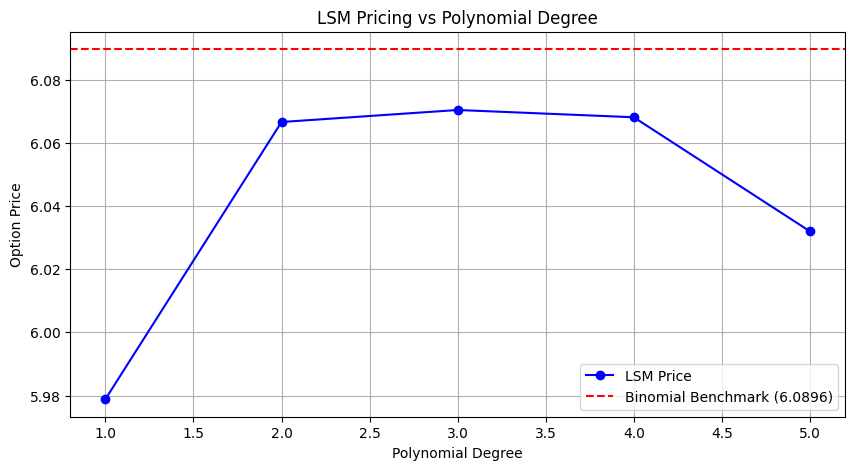

In [9]:
start=time()
binomial_price=Binomial(S0,K,r,sigma,T,N_tree)
binomial_time=time()-start
print(f"Option Value for BT ({N_tree} steps): {binomial_price:.4f},Time: {binomial_time:.2f}s")

degrees=[1,2,3,4,5]
results=[]
for degree in degrees:
    start=time()
    lsm_price=lsm_fit_model(S0,K,r,sigma,T,N_lsm,M,degree)
    lsm_time=time()-start
    error_pct=100*(lsm_price-binomial_price)/binomial_price
    results.append({'Method': 'LSM','Degree': degree,'Price': lsm_price,'Error (%)': error_pct,'Time (s)': lsm_time})
    print(f"Degree {degree}: {lsm_price:.4f} (Error: {error_pct:.2f}%), Time: {lsm_time:.2f}s")

results_df=pd.DataFrame(results)
print(results_df[['Degree', 'Price', 'Error (%)', 'Time (s)']])

#Visualization
plt.figure(figsize=(10, 5))
plt.plot(degrees, results_df['Price'], 'bo-', label='LSM Price')
plt.axhline(y=binomial_price, color='r', linestyle='--', label=f'Binomial Benchmark ({binomial_price:.4f})')
plt.xlabel('Polynomial Degree')
plt.ylabel('Option Price')
plt.title('LSM Pricing vs Polynomial Degree')
plt.legend()
plt.grid(True)
plt.show()